In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *

from pyfrac.modelling.kirchhoff import Kirchhoff

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

In [3]:
trans_file = '/media/birniece/Extreme SSD/HydraFrac/DropBall/DropBall_Feb27/droptestFW1.csv'

In [4]:
df = pd.read_csv(trans_file, skiprows=9, index_col=0, header=None )
df.dropna(axis=1, inplace=True)
df.columns = ['R1','R2','R3','R4','R5','R6','R7','R8']
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8
0,,,,,,,,
0.00000,0.002340,0.001545,0.001295,-0.000156,0.001669,0.001606,0.000710,0.000659
0.00001,0.002292,0.001600,0.001308,-0.000163,0.001669,0.001707,0.000741,0.000824
0.00002,0.002326,0.001637,0.001348,-0.000122,0.001659,0.001680,0.000727,0.000798
0.00003,0.002221,0.001551,0.001247,-0.000229,0.001584,0.001708,0.000626,0.000736
0.00004,0.002311,0.001531,0.001318,-0.000170,0.001708,0.001754,0.000674,0.000721


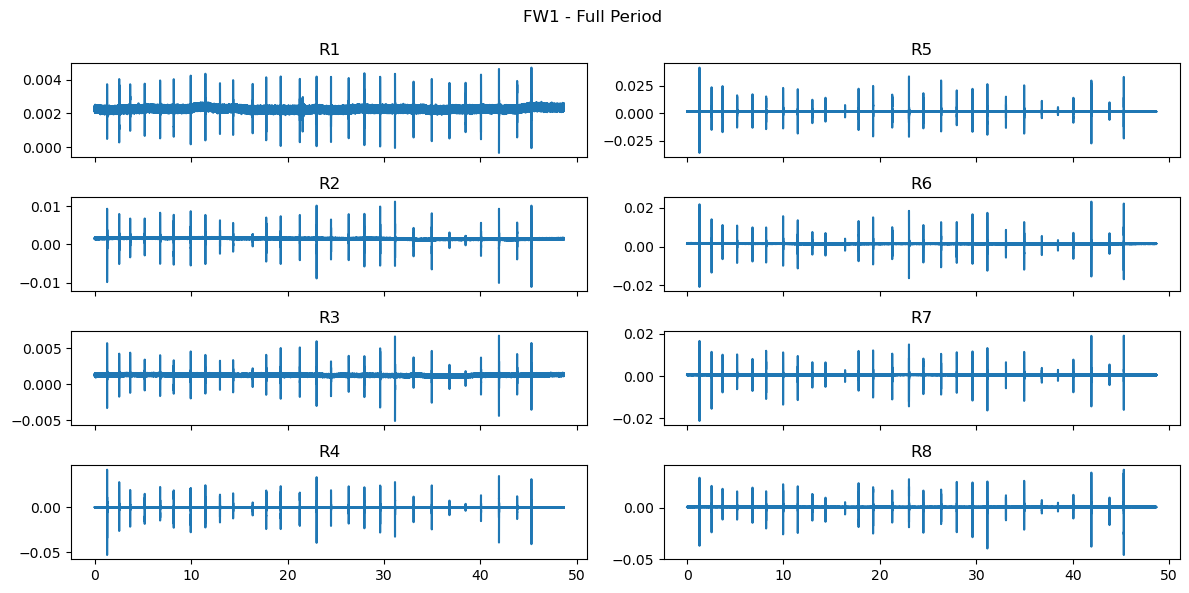

In [5]:
fig,axs = plt.subplots(4,2,figsize=[12,6], sharex=True)
axs[0,0].plot(df['R1'])
axs[1,0].plot(df['R2'])
axs[2,0].plot(df['R3'])
axs[3,0].plot(df['R4'])
axs[0,1].plot(df['R5'])
axs[1,1].plot(df['R6'])
axs[2,1].plot(df['R7'])
axs[3,1].plot(df['R8'])

axs[0,0].set_title('R1')
axs[1,0].set_title('R2')
axs[2,0].set_title('R3')
axs[3,0].set_title('R4')
axs[0,1].set_title('R5')
axs[1,1].set_title('R6')
axs[2,1].set_title('R7')
axs[3,1].set_title('R8')

# for ax in axs[-1,:]:ax.set_xlabel('Time (s)'), ax.set_xlim([0,110])
    
fig.suptitle('FW1 - Full Period ')
fig.tight_layout()

(3.675, 3.725)

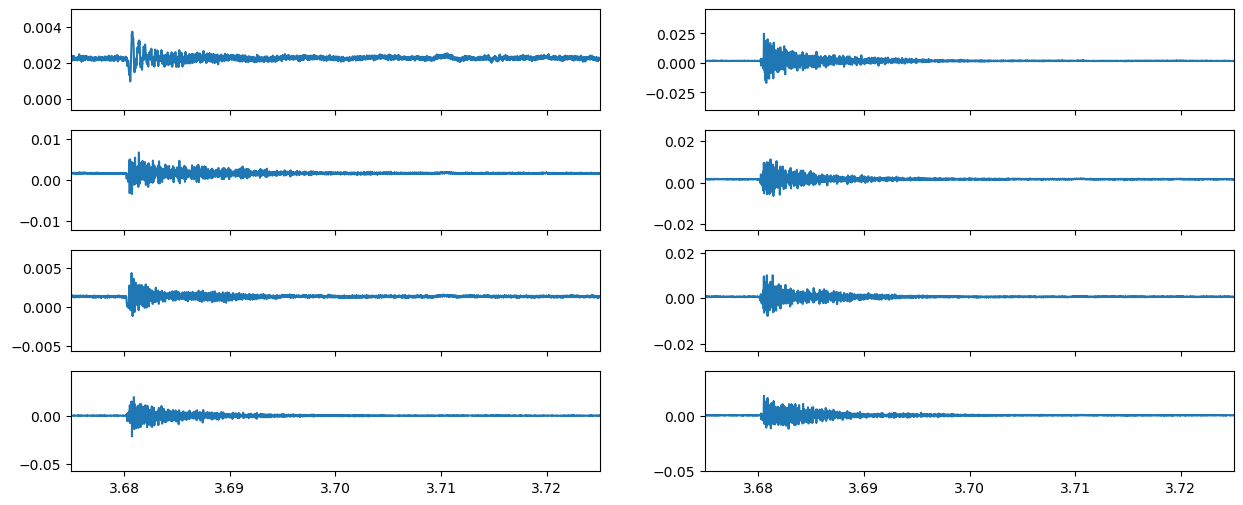

In [6]:
fig,axs = plt.subplots(4,2,figsize=[15,6], sharex=True)
axs[0,0].plot(df['R1'])
axs[1,0].plot(df['R2'])
axs[2,0].plot(df['R3'])
axs[3,0].plot(df['R4'])
axs[0,1].plot(df['R5'])
axs[1,1].plot(df['R6'])
axs[2,1].plot(df['R7'])
axs[3,1].plot(df['R8'])

axs[0,0].set_xlim([3.675,3.725])

(3.679, 3.682)

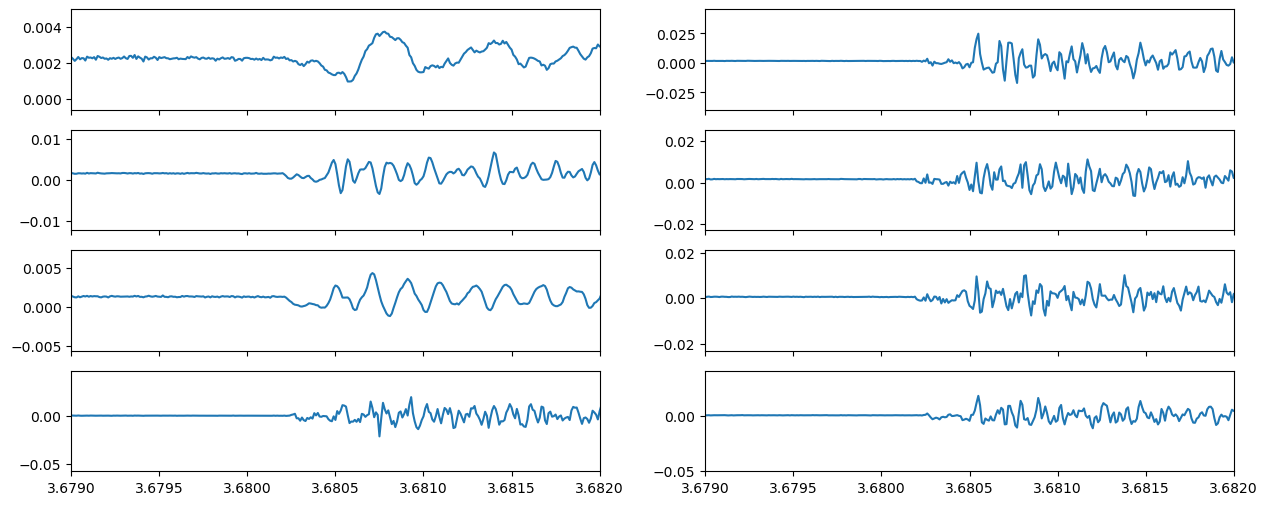

In [7]:
fig,axs = plt.subplots(4,2,figsize=[15,6], sharex=True)
axs[0,0].plot(df['R1'])
axs[1,0].plot(df['R2'])
axs[2,0].plot(df['R3'])
axs[3,0].plot(df['R4'])
axs[0,1].plot(df['R5'])
axs[1,1].plot(df['R6'])
axs[2,1].plot(df['R7'])
axs[3,1].plot(df['R8'])

axs[0,0].set_xlim([3.679,3.682])

# TRY IMAGING

In [17]:
# Load velocity model
dx = dy = dz = 0.01
dimlims = 0.41
nx = ny = nz = int(dimlims/dx)
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
print(x)
# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 ]


In [14]:
# RECEIVERS
outer_dist = 1.5*np.cos(45)
inner_dist = 15.5
full=40.5

# 0,0 closest to 8 
recs_xyz = np.array([(full-outer_dist, full-outer_dist, 0), #1
                    (full-inner_dist,full-inner_dist, 0), #2
                    (full-inner_dist,inner_dist, 0), #3
                    (full-outer_dist,outer_dist, 0), #4
                    (outer_dist,full-outer_dist, 0), #5
                    (inner_dist,full-inner_dist, 0), #6
                    (inner_dist,inner_dist, 0), #7
                    (outer_dist,outer_dist, 0), #8
                   ]).T
recs_xyz /= 100 

nr = recs_xyz.shape[1]
print(recs_xyz)

[[0.39712017 0.25       0.25       0.39712017 0.00787983 0.155
  0.155      0.00787983]
 [0.39712017 0.25       0.155      0.00787983 0.39712017 0.25
  0.155      0.00787983]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [28]:
# Microseismic sources
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

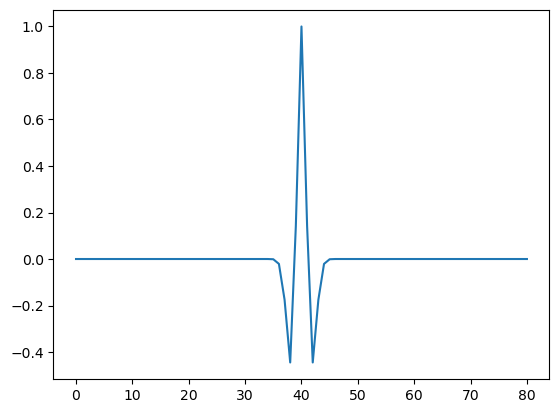

In [21]:
nt = 251
dt = 0.0001
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=2000)
plt.plot(wav)

In [29]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs_xyz[:, :1], 
               recs=recs_xyz, 
               vel=vp*np.ones([nx,ny,nz]), 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/modelling/kirchhoff.py:255: FutureWarning: A new implementation of Kirchhoff is provided in v2.1.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to providethe variables trav (and amp) as a tuples containing the traveltime (and amplitude) tables for sources and receivers separately. This behaviour will eventually become default in version v3.0.0.
  warnings.warn(


Dot test passed, v^H(Opu)=171.65792088539953 - u^H(Op^Hv)=171.65792088540064


Text(0.5, 1.0, 'Point Receivers')

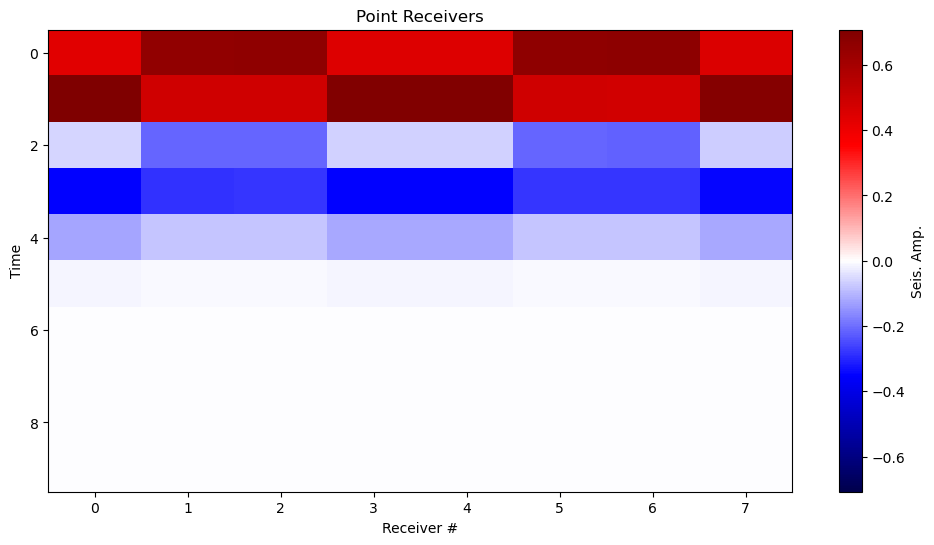

In [30]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
ax = traceimage(frwddata[:,:10], climQ=99.99)
ax.set_title('Point Receivers')

In [31]:
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

Migration Hypo-Centers: [18.8 18.9  0. ]


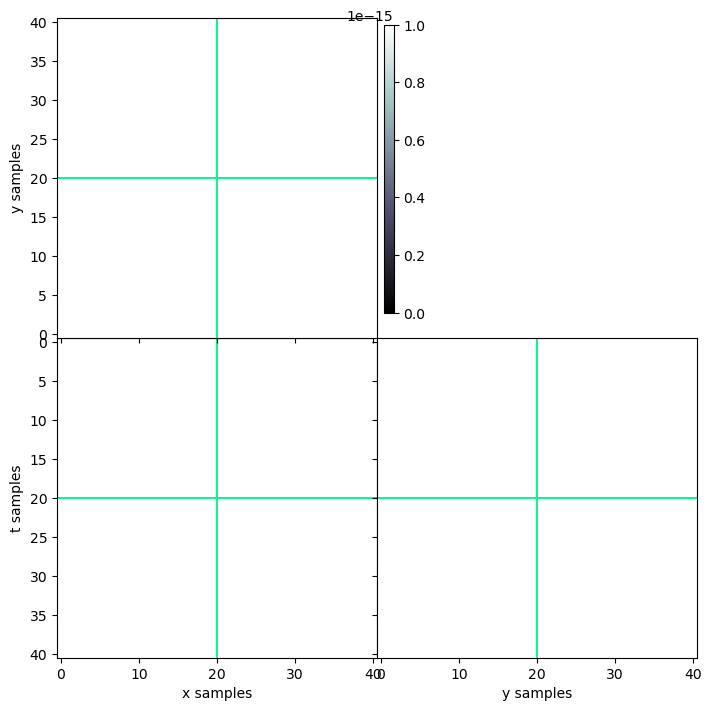

In [38]:
migrated, mig_hc = migration(Op, frwddata, [nx,ny,nz], nforhc=10)  # (Op.H @ frwddata).reshape(nx,ny,nz)
print('Migration Hypo-Centers:', mig_hc)

fig,axs = locimage3d(migrated,sx,sy, clipval=[0,1e-15])